# multilingual-sentimentsデータでfinetuning

In [1]:
import torch
# GPUが使用可能か判断
if torch.cuda.is_available():
    print('gpu is available')
else:
    raise Exception('gpu is NOT available')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

gpu is available


device(type='cuda')

In [2]:
# !pip install transformers[torch] datasets
# !pip install fugashi
# !pip install ipadic
# !pip install sentencepiece

In [3]:
# !pip install git+https://github.com/huggingface/accelerate
# !pip install --upgrade transformers

In [4]:
# !pip install optuna

In [5]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import torch
import random

In [6]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

## データ取得

In [7]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/wrime-sentimentのリポジトリから
# データを読み込む
train_dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese", split="train")
valid_dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese", split="validation")
# pprintで見やすく表示する
pprint(train_dataset)
pprint(valid_dataset)

Dataset({
    features: ['text', 'source', 'label'],
    num_rows: 120000
})
Dataset({
    features: ['text', 'source', 'label'],
    num_rows: 3000
})


In [8]:
# 実験のためデータセットを縮小したい場合はコチラを有効化
train_dataset = train_dataset.select(
    random.sample(range(train_dataset.num_rows), k=500))
valid_dataset = valid_dataset.select(
    random.sample(range(valid_dataset.num_rows), k=500))
pprint(train_dataset)
pprint(valid_dataset)

Dataset({
    features: ['text', 'source', 'label'],
    num_rows: 500
})
Dataset({
    features: ['text', 'source', 'label'],
    num_rows: 500
})


## データ前処理

In [9]:
# トークナイザのロード
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
# トークナイザ実行用関数
def preprocess_text(batch):
    encoded_batch = tokenizer(batch['text'], max_length=512)
    encoded_batch['labels'] = batch['label']
    return encoded_batch

In [11]:
# トークナイズ＋エンコード処理実行
encoded_train_dataset = train_dataset.map(
    preprocess_text,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text,
    remove_columns=valid_dataset.column_names,
)

In [12]:
# ミニバッチ構築
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 最適化するハイパーパラメータの設定

In [13]:
# オプティマイザ
OPTIMIZER_NAME = "adamw_torch"

# 最適化するハイパーパラメータ
def optuna_hp_space(trial):
    return {
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["constant", "linear", "cosine"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        # "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16]),
        "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4, 8, 16]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-1, log=True),
    }

In [14]:
# モデルの準備
from transformers import AutoModelForSequenceClassification

def model_init(trial):
    class_label = train_dataset.features["label"]
    label2id = {label: id for id, label in enumerate(class_label.names)}
    id2label = {id: label for id, label in enumerate(class_label.names)}
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=class_label.num_classes,
        label2id=label2id,  # ラベル名からIDへの対応を指定
        id2label=id2label,  # IDからラベル名への対応を指定
    )
    return model

In [15]:
# 訓練の実行
from transformers import TrainingArguments

training_args = TrainingArguments(
    optim=OPTIMIZER_NAME,  # オプティマイザの種類(adamw_torch/adafactor)
    output_dir="output_multilingual",  # 結果の保存フォルダ
    per_device_train_batch_size=16,  # 訓練時のバッチサイズ
    # gradient_accumulation_steps=1, # 勾配累積
    # per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    # learning_rate=2e-5,  # 学習率
    # lr_scheduler_type="constant",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
)

In [16]:
# メトリクスの定義
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

## ハイパーパラメータ探索

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=None,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    model_init=model_init,
)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def compute_objective(metrics):
    return metrics["eval_f1"]

In [19]:
# ハイパーパラメータ探索
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=2,
    compute_objective=compute_objective,
)

[I 2023-10-01 12:50:36,595] A new study created in memory with name: no-name-fc40d0ee-3387-439a-ad0a-f68bb3416594
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.094100,1.090664,0.434000,0.357491
2,1.041900,1.066417,0.500000,0.421317
3,1.019700,1.059355,0.504000,0.426113


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.103000,1.096738,0.352000,0.262752
2,1.060900,1.085087,0.364000,0.254535
3,1.039000,1.079425,0.410000,0.316380


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

In [20]:
# ベスト-ハイパーパラメータ
print(best_trial)
print(best_trial.hyperparameters)
print(OPTIMIZER_NAME)
print(best_trial.hyperparameters['lr_scheduler_type'])
print(best_trial.hyperparameters['learning_rate'])
print(best_trial.hyperparameters['gradient_accumulation_steps'])
print(best_trial.hyperparameters['weight_decay'])

BestRun(run_id='0', objective=0.4261133461047254, hyperparameters={'lr_scheduler_type': 'cosine', 'learning_rate': 7.224709095288059e-06, 'gradient_accumulation_steps': 2, 'weight_decay': 4.727492471250209e-06}, run_summary=None)
{'lr_scheduler_type': 'cosine', 'learning_rate': 7.224709095288059e-06, 'gradient_accumulation_steps': 2, 'weight_decay': 4.727492471250209e-06}
adamw_torch
cosine
7.224709095288059e-06
2
4.727492471250209e-06


## 最適化されたハイパーパラメータでFineTuning

In [21]:
# モデルの準備
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [22]:
# 訓練用の設定
from transformers import TrainingArguments

# ベストパラメータ
best_lr_type = best_trial.hyperparameters['lr_scheduler_type']
best_lr = best_trial.hyperparameters['learning_rate']
best_grad_acc_steps = best_trial.hyperparameters['gradient_accumulation_steps']
best_weight_decay = best_trial.hyperparameters['weight_decay']
# 保存ディレクトリ
save_dir = f'bert-finetuned-multilingual-sentiments-{OPTIMIZER_NAME}'

training_args = TrainingArguments(
    output_dir=save_dir,  # 結果の保存フォルダ
    optim=OPTIMIZER_NAME,  # オプティマイザの種類
    per_device_train_batch_size=16,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=16,  # 評価時のバッチサイズ
    gradient_accumulation_steps=best_grad_acc_steps,  # 勾配累積
    learning_rate=best_lr,  # 学習率
    lr_scheduler_type=best_lr_type,  # 学習率スケジューラの種類
    weight_decay=best_weight_decay,  # 正則化
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=100,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
)

In [23]:
# 訓練の実施
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.111900,1.147005,0.318000,0.154416
2,1.106600,1.125057,0.318000,0.164681
3,1.083700,1.098004,0.364000,0.265481
4,1.051100,1.072445,0.440000,0.342186
5,1.024700,1.033027,0.490000,0.393695
6,0.960900,0.974452,0.528000,0.421623
7,0.865200,0.878718,0.560000,0.473514
8,0.747000,0.800212,0.602000,0.558534
9,0.638600,0.724805,0.660000,0.645580
10,0.547000,0.686064,0.688000,0.670174


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

TrainOutput(global_step=288, training_loss=0.6249488691488901, metrics={'train_runtime': 708.1474, 'train_samples_per_second': 70.607, 'train_steps_per_second': 2.259, 'total_flos': 898112984531616.0, 'train_loss': 0.6249488691488901, 'epoch': 18.0})

In [24]:
# モデルの保存
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


('bert-finetuned-multilingual-sentiments-adamw_torch/tokenizer_config.json',
 'bert-finetuned-multilingual-sentiments-adamw_torch/special_tokens_map.json',
 'bert-finetuned-multilingual-sentiments-adamw_torch/vocab.txt',
 'bert-finetuned-multilingual-sentiments-adamw_torch/added_tokens.json')

In [25]:
# 結果描画用関数
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def linear_regression(history_df):
    y = history_df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    linear = LinearRegression().fit(x, y)
    return linear

def show_graph(df, suptitle, regression, output='output.png'):
    suptitle_size = 23
    graph_title_size = 20
    legend_size = 18
    ticks_size = 13
    # 学習曲線
    fig = plt.figure(figsize=(20, 5))
    # plt.suptitle(','.join([f'{e}: {parameters[e]}' for e in parameters.keys()]), fontsize=suptitle_size)
    plt.suptitle(suptitle, fontsize=suptitle_size)
    # Train Loss
    plt.subplot(131)
    plt.title('Train Loss', fontsize=graph_title_size)
    plt.plot(df['loss'].dropna(), label='train')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    # Validation Loss
    plt.subplot(132)
    reg_str = f'$y={round(regression.coef_[0],5)}*x+{round(regression.intercept_,3)}$'
    plt.title(f'Val Loss', fontsize=graph_title_size)
    y = df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    pred = regression.coef_ * x.ravel() + regression.intercept_  # 線形回帰直線
    plt.plot(y, color='tab:orange', label='val')
    plt.plot(pred, color='green', label='pred')
    plt.legend(fontsize=legend_size)
    plt.xlabel(reg_str, fontsize=ticks_size)
    plt.yticks(fontsize=ticks_size)
    # Accuracy/F1
    plt.subplot(133)
    plt.title('eval Accuracy/F1', fontsize=graph_title_size)
    plt.plot(df['eval_accuracy'].dropna(), label='accuracy')
    plt.plot(df['eval_f1'].dropna(), label='F1')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    plt.tight_layout()
    # plt.show()
    plt.savefig(output)

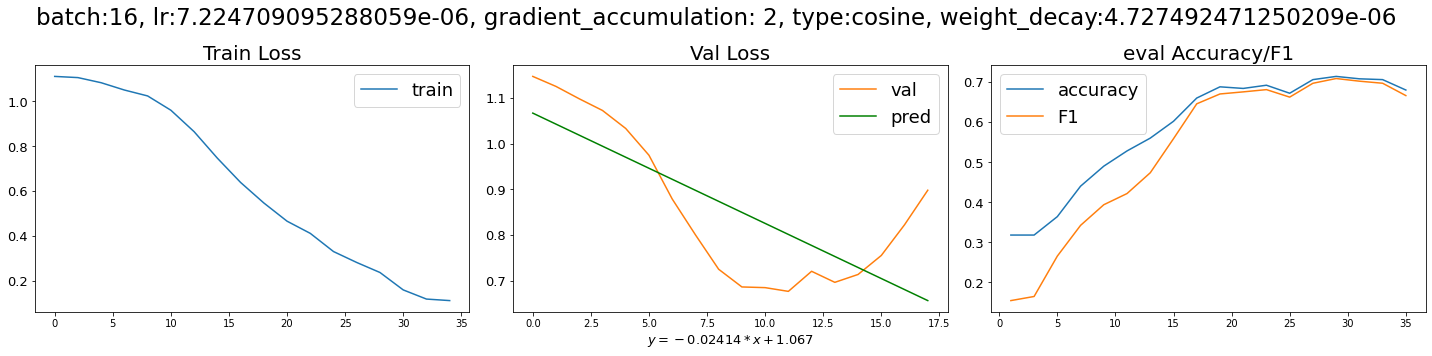

In [26]:
history_df = pd.DataFrame(trainer.state.log_history)
# 結果を表示
suptitle = f'batch:16, lr:{best_lr}, gradient_accumulation: {best_grad_acc_steps}, type:{best_lr_type}, weight_decay:{best_weight_decay}'
reg = linear_regression(history_df)
show_graph(history_df, suptitle, reg, f'{save_dir}/output.png')